density=0.10  shell=2x0.42mm
  A_shell  = 30.78 mm^2
  L_infill = 15.10 mm
  A_infill = 6.34 mm^2
  A_total  = 37.12 mm^2


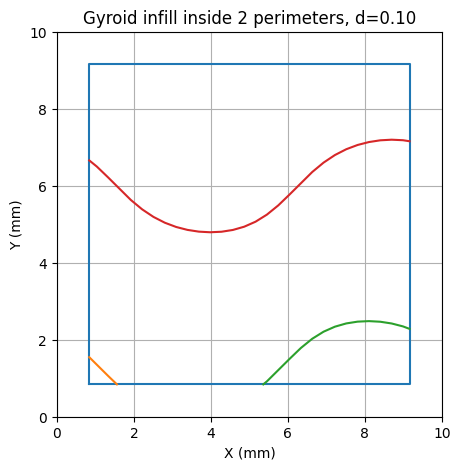

density=0.15  shell=2x0.42mm
  A_shell  = 30.78 mm^2
  L_infill = 28.05 mm
  A_infill = 11.78 mm^2
  A_total  = 42.56 mm^2


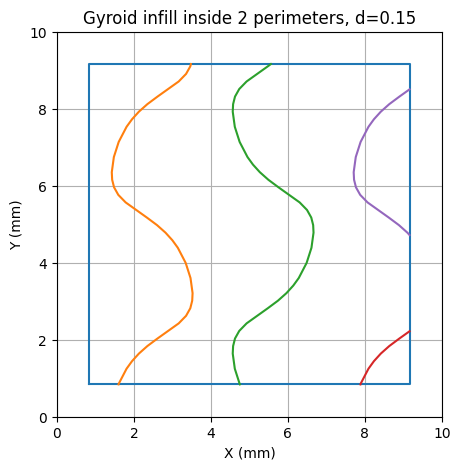

density=0.60  shell=2x0.42mm
  A_shell  = 30.78 mm^2
  L_infill = 119.42 mm
  A_infill = 50.16 mm^2
  A_total  = 80.93 mm^2


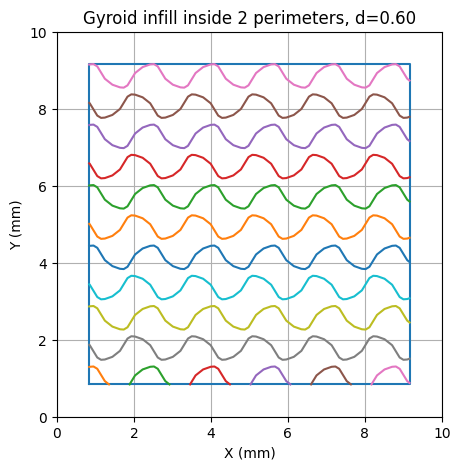

In [14]:
import numpy as np
from math import ceil, pi

EPS = 1e-9

# ----------------- Prusa gyroid core -----------------

def prusa_f(x, z_sin, z_cos, vertical, flip):
    if vertical:
        phase_offset = (np.pi if z_cos < 0 else 0.0) + np.pi
        a   = np.sin(x + phase_offset)
        b   = -z_cos
        res = z_sin * np.cos(x + phase_offset + (np.pi if flip else 0.0))
        r   = np.sqrt(a*a + b*b)
        return np.arcsin(a/r) + np.arcsin(res/r) + np.pi
    else:
        phase_offset = np.pi if z_sin < 0.0 else 0.0
        a   = np.cos(x + phase_offset)
        b   = -z_sin
        res = z_cos * np.sin(x + phase_offset + (0.0 if flip else np.pi))
        r   = np.sqrt(a*a + b*b)
        return np.arcsin(a/r) + np.arcsin(res/r) + 0.5*np.pi

def _cross2(ax, ay, bx, by): return ax*by - ay*bx

def make_one_period(width_units, z_cos, z_sin, vertical, flip, tol_units):
    dx = np.pi/2.0
    limit = min(2.0*np.pi, width_units)
    xs = list(np.arange(0.0, limit-EPS, dx)) + [limit]
    pts = [[x, prusa_f(x, z_sin, z_cos, vertical, flip)] for x in xs]
    # refinement loop
    while True:
        n0 = len(pts)
        new = [pts[0]]
        for i in range(1, len(pts)):
            lx, ly = new[-1]
            rx, ry = pts[i]
            xm = 0.5*(lx + rx)
            ym = prusa_f(xm, z_sin, z_cos, vertical, flip)
            if abs(_cross2(xm-lx, ym-ly, xm-rx, ym-ry)) > tol_units*tol_units:
                new.append([xm, ym])
            new.append([rx, ry])
        pts = new
        if len(pts) == n0: break
        pts.sort(key=lambda p: p[0])
    return np.asarray(pts)

def make_wave(one_period, width_units, height_units, y0, scale_mm_per_unit,
              z_cos, z_sin, vertical, flip):
    pts = one_period.copy()
    period = pts[-1,0]
    if abs(width_units - period) > EPS:
        n = len(pts)
        pts = pts[:-1].tolist()
        while pts[-1][0] < width_units - EPS:
            src = pts[-n+1]
            pts.append([src[0] + period, src[1]])
        y_end = prusa_f(width_units, z_sin, z_cos, vertical, flip)
        pts.append([width_units, y_end])
    else:
        pts = pts.tolist()

    out = []
    for x,y in pts:
        y = y + y0
        y = min(max(y, 0.0), height_units)   # clamp like Prusa
        if vertical: x, y = y, x             # swap *after* clamp
        out.append([x*scale_mm_per_unit, y*scale_mm_per_unit])
    return np.asarray(out)

def make_gyroid_waves_prusa(z_mm, density, spacing_mm, width_mm, height_mm,
                            density_adjust=1.0, pattern_tolerance_mm=0.5,
                            pad_modules=int(ceil(2.0*np.pi))):
    """
    Returns list of polylines (Nx2 arrays) in mm (NOT clipped).
    """
    dens = max(0.0, density * density_adjust)
    if dens <= 0.0: return []

    scale = spacing_mm / dens      # mm per “unit”
    tol_units = min(spacing_mm/2.0, pattern_tolerance_mm) / scale

    # z in “units”
    z = z_mm / scale
    z_sin, z_cos = np.sin(z), np.cos(z)

    # Prusa-like module counts (ceil + 1)
    modules_x = int(ceil(width_mm  / scale)) + 1
    modules_y = int(ceil(height_mm / scale)) + 1

    # emulate align_to_grid padding (2π “modules”)
    Wm = modules_x + pad_modules
    Hm = modules_y + pad_modules

    vertical = (abs(z_sin) <= abs(z_cos))
    lower, upper = 0.0, Hm
    flip = True
    if vertical:
        flip = False
        lower = -np.pi
        upper = Wm - np.pi/2.0
        Wm, Hm = Hm, Wm            # swap like the C++ after computing bounds

    odd  = make_one_period(Wm, z_cos, z_sin, vertical, flip, tol_units)
    flip = not flip
    even = make_one_period(Wm, z_cos, z_sin, vertical, flip, tol_units)

    lines = []
    y0 = lower
    while y0 < upper + EPS:
        lines.append(make_wave(odd,  Wm, Hm, y0, scale, z_cos, z_sin, vertical, flip))
        y0 += np.pi
        if y0 < upper + EPS:
            lines.append(make_wave(even, Wm, Hm, y0, scale, z_cos, z_sin, vertical, flip))
        y0 += np.pi

    # translate back by the padding so the original box sits inside
    shift_mm = pad_modules * scale
    for i in range(len(lines)):
        lines[i][:,0] -= shift_mm
        lines[i][:,1] -= shift_mm
    return lines

# ----------------- rectangle clipping & length -----------------

INSIDE, LEFT, RIGHT, BOTTOM, TOP = 0, 1, 2, 4, 8

def _outcode(x, y, xmin, ymin, xmax, ymax):
    code = INSIDE
    if x < xmin: code |= LEFT
    elif x > xmax: code |= RIGHT
    if y < ymin: code |= BOTTOM
    elif y > ymax: code |= TOP
    return code

def _clip_segment(x0, y0, x1, y1, xmin, ymin, xmax, ymax):
    c0 = _outcode(x0, y0, xmin, ymin, xmax, ymax)
    c1 = _outcode(x1, y1, xmin, ymin, xmax, ymax)
    while True:
        if not (c0 | c1):
            return x0, y0, x1, y1, True
        if c0 & c1:
            return 0, 0, 0, 0, False
        c = c0 or c1
        if c & TOP:
            x = x0 + (x1 - x0) * (ymax - y0) / (y1 - y0); y = ymax
        elif c & BOTTOM:
            x = x0 + (x1 - x0) * (ymin - y0) / (y1 - y0); y = ymin
        elif c & RIGHT:
            y = y0 + (y1 - y0) * (xmax - x0) / (x1 - x0); x = xmax
        else:
            y = y0 + (y1 - y0) * (xmin - x0) / (x1 - x0); x = xmin
        if c == c0:
            x0, y0 = x, y; c0 = _outcode(x0, y0, xmin, ymin, xmax, ymax)
        else:
            x1, y1 = x, y; c1 = _outcode(x1, y1, xmin, ymin, xmax, ymax)

def _clip_polylines_to_rect(lines, xmin, ymin, xmax, ymax):
    out = []
    for P in lines:
        if len(P) < 2: continue
        cur = []
        for i in range(len(P)-1):
            x0,y0 = P[i]
            x1,y1 = P[i+1]
            x0c,y0c,x1c,y1c,ok = _clip_segment(x0,y0,x1,y1,xmin,ymin,xmax,ymax)
            if not ok:
                if cur: out.append(np.array(cur)); cur=[]
                continue
            if not cur:
                cur = [[x0c,y0c],[x1c,y1c]]
            else:
                if abs(cur[-1][0]-x0c) > 1e-9 or abs(cur[-1][1]-y0c) > 1e-9:
                    out.append(np.array(cur)); cur=[[x0c,y0c],[x1c,y1c]]
                else:
                    cur.append([x1c,y1c])
        if cur: out.append(np.array(cur))
    return out

def _total_length_mm(lines):
    L = 0.0
    for P in lines:
        if len(P) < 2: continue
        d = np.diff(P, axis=0)
        L += float(np.sum(np.hypot(d[:,0], d[:,1])))
    return L

# ----------------- area calculator with shell -----------------

def compute_areas_with_shell(width_mm, height_mm,
                             z_mm, spacing_mm, density,
                             line_width_mm,
                             shell_perimeters=2,
                             density_adjust=1.0,
                             pattern_tolerance_mm=0.5,
                             phase_shift_mm=(0.0, 0.0)):
    """
    Returns a dict with:
      A_shell, A_infill, A_total, L_infill, lines_infill (clipped), inner_box (x0,y0,W_in,H_in)
    """
    # --- exact rectangular shell area ---
    t = shell_perimeters * line_width_mm
    W_in = max(0.0, width_mm  - 2.0*t)
    H_in = max(0.0, height_mm - 2.0*t)
    A_shell = width_mm*height_mm - (W_in * H_in)

    # --- generate waves and clip to the inner rectangle ---
    if W_in <= 0.0 or H_in <= 0.0:
        # no infill area remains
        return {
            "A_shell": A_shell,
            "A_infill": 0.0,
            "A_total": A_shell,
            "L_infill": 0.0,
            "lines_infill": [],
            "inner_box": (0.0, 0.0, 0.0, 0.0)
        }

    # generate full pattern (unclipped)
    raw = make_gyroid_waves_prusa(
        z_mm, density, spacing_mm, width_mm, height_mm,
        density_adjust=density_adjust, pattern_tolerance_mm=pattern_tolerance_mm
    )

    # Optional small phase shift to avoid degenerate lines exactly on borders
    if phase_shift_mm != (0.0, 0.0):
        dx, dy = phase_shift_mm
        raw = [P + np.array([dx, dy]) for P in raw]

    # clip to inner rect [t, t] – [t+W_in, t+H_in]
    lines_infill = _clip_polylines_to_rect(raw, t, t, t + W_in, t + H_in)

    # area ≈ total extruded length × line width
    L_infill = _total_length_mm(lines_infill)
    A_infill = L_infill * line_width_mm
    A_total  = A_shell + A_infill

    return {
        "A_shell": A_shell,
        "A_infill": A_infill,
        "A_total": A_total,
        "L_infill": L_infill,
        "lines_infill": lines_infill,
        "inner_box": (t, t, W_in, H_in)
    }

# ----------------- example -----------------
if __name__ == "__main__":
    # Your test values:
    W = H = 10.0
    z = 12
    spacing = 0.15
    line_w = 0.42
    perims = 2

    for d in (0.10, 0.15, 0.60):
        res = compute_areas_with_shell(
            width_mm=W, height_mm=H,
            z_mm=z, spacing_mm=spacing, density=d,
            line_width_mm=line_w, shell_perimeters=perims,
            density_adjust=1.0, pattern_tolerance_mm=0.5,
            phase_shift_mm=(0.05, 0.0)  # tiny shift so lines don't land on the frame
        )
        print(f"density={d:.2f}  shell={perims}x{line_w:.2f}mm")
        print(f"  A_shell  = {res['A_shell']:.2f} mm^2")
        print(f"  L_infill = {res['L_infill']:.2f} mm")
        print(f"  A_infill = {res['A_infill']:.2f} mm^2")
        print(f"  A_total  = {res['A_total']:.2f} mm^2")

        # Optional: plot the infill inside the shell
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,5))
        # draw shell rectangle
        t = perims*line_w
        plt.plot([t, t+res["inner_box"][2], t+res["inner_box"][2], t, t],
                 [t, t, t+res["inner_box"][3], t+res["inner_box"][3], t])
        for P in res["lines_infill"]:
            if len(P) >= 2:
                plt.plot(P[:,0], P[:,1])
        plt.xlim(0, W); plt.ylim(0, H); plt.gca().set_aspect('equal'); plt.grid(True)
        plt.title(f"Gyroid infill inside {perims} perimeters, d={d:.2f}")
        plt.xlabel("X (mm)"); plt.ylabel("Y (mm)")
        plt.show()


Infill max area: 14.30 mm² at z = 7.07 mm
Infill min area: 9.58 mm² at z = 1.62 mm
Shell area: 30.78 mm²
Infill area ratio: 49.23 %
Infill area ratio: 49.23 %


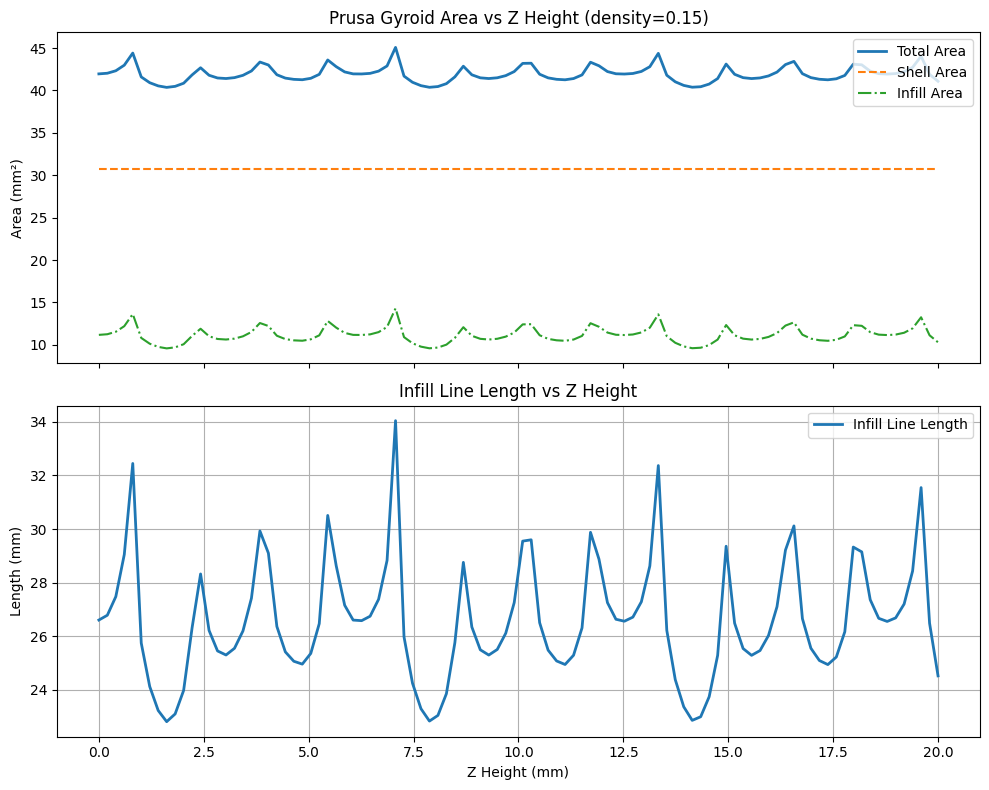

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Parameters (same as before)
width = 10.0
height = 10.0
infill_fraction = 0.15
shell_layers = 2
line_thickness = 0.42
spacing_mm = 0.15  # Prusa “module size”
z_heights = np.linspace(0, 20, 100)

# Data storage
areas = []
shell_areas = []
infill_areas = []
lengths = []

# Loop using Prusa model
for z in z_heights:
    result = compute_areas_with_shell(
        width_mm=width,
        height_mm=height,
        z_mm=z,
        spacing_mm=spacing_mm,
        density=infill_fraction,
        line_width_mm=line_thickness,
        shell_perimeters=shell_layers,
        density_adjust=1.0,
        pattern_tolerance_mm=0.5,
        phase_shift_mm=(0.05, 0.0)
    )

    areas.append(result["A_total"])
    shell_areas.append(result["A_shell"])
    infill_areas.append(result["A_infill"])
    lengths.append(result["L_infill"])

# Convert to NumPy for analysis
z_np = np.array(z_heights)
areas_np = np.array(areas)
shell_areas_np = np.array(shell_areas)
infill_areas_np = np.array(infill_areas)
lengths_np = np.array(lengths)

# Analyze
i_max = np.argmax(infill_areas_np)
i_min = np.argmin(infill_areas_np)
print(f"Infill max area: {infill_areas_np[i_max]:.2f} mm² at z = {z_np[i_max]:.2f} mm")
print(f"Infill min area: {infill_areas_np[i_min]:.2f} mm² at z = {z_np[i_min]:.2f} mm")
print(f"Shell area: {shell_areas_np[i_min]:.2f} mm²")
#infill_peak_area_ratio = (infill_areas_np[i_max] / infill_areas_np[i_min] - 1) * 100
if infill_areas_np[i_min] > 1e-6:
    infill_peak_area_ratio = (infill_areas_np[i_max] / infill_areas_np[i_min] - 1) * 100
    print(f"Infill area ratio: {infill_peak_area_ratio:.2f} %")
else:
    print("Infill min area is zero — cannot compute ratio.")

print(f"Infill area ratio: {infill_peak_area_ratio:.2f} %")

# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(z_np, areas_np, label="Total Area", linewidth=2)
axs[0].plot(z_np, shell_areas_np, label="Shell Area", linestyle='--')
axs[0].plot(z_np, infill_areas_np, label="Infill Area", linestyle='-.')
axs[0].set_ylabel("Area (mm²)")
axs[0].legend()
axs[0].set_title(f"Prusa Gyroid Area vs Z Height (density={infill_fraction:.2f})")

axs[1].plot(z_np, lengths_np, label="Infill Line Length", linewidth=2)
axs[1].set_ylabel("Length (mm)")
axs[1].set_xlabel("Z Height (mm)")
axs[1].set_title("Infill Line Length vs Z Height")
axs[1].legend()

plt.tight_layout()
plt.grid(True)
plt.show()
